# CoinGame solver using multi-agent advantage actor-critic (MAA2C) with a shared classical policy and joint classical critic.

In [8]:
import sys
sys.path.append('../') # Use parent dir.

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import eqmarl
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from pathlib import Path
import numpy as np
import cirq
import functools as ft
from datetime import datetime

In [11]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [12]:
output_dir = Path('./output/')
root_dir = output_dir/'coingame_maa2c_quantum_pomdp_nnreduce_4qubits'
root_dir.expanduser().mkdir(parents=True, exist_ok=True)

checkpoint_dir = root_dir / 'checkpoints'

metrics_file = root_dir / 'metrics-{datetime}.json'
model_actor_checkpoint_file = checkpoint_dir / 'actor' / 'cp-{datetime}.ckpt'
model_critic_checkpoint_file = checkpoint_dir / 'critic' / 'cp-{datetime}.ckpt'

In [13]:
n_actions = 4
n_agents = 2
observation_dim = 36

In [14]:
d_qubits = 4
n_layers = 5
keepdims = [0,2,3] # Preserves observations indices [0,2,3], removes index [1] which contains info about other agent locations -- makes observation partially-observable.


# Quantum shared actor.
model_actor = eqmarl.models.generate_model_CoinGame2_actor_quantum_nnreduce_shared_pomdp(
    d_qubits=d_qubits,
    keepdims=keepdims,
    n_layers=n_layers,
    trainable_w_enc=False,
    name=f"actor-quantum-shared",
    )
optimizer_actor = [
    keras.optimizers.Adam(learning_rate=1e-3), #dense kernel
    keras.optimizers.Adam(learning_rate=1e-3), #dense bias
    keras.optimizers.Adam(learning_rate=1e-2), # w_var
    # keras.optimizers.Adam(learning_rate=1e-1), # w_enc
    keras.optimizers.Adam(learning_rate=1e-1), # obs_weights
    ]

model_actor.build((None, observation_dim))
model_actor.summary()


# Quantum joint critic.
model_critic = eqmarl.models.generate_model_CoinGame2_critic_quantum_nnreduce_partite_pomdp(
    d_qubits=d_qubits,
    keepdims=keepdims,
    n_agents=n_agents,
    n_layers=n_layers,
    trainable_w_enc=False,
    name=f"critic-quantum-joint",
    )
optimizer_critic = [
    keras.optimizers.Adam(learning_rate=1e-3), #dense kernel
    keras.optimizers.Adam(learning_rate=1e-3), #dense bias
    keras.optimizers.Adam(learning_rate=1e-2), # w_var
    # keras.optimizers.Adam(learning_rate=1e-1), # w_enc
    keras.optimizers.Adam(learning_rate=1e-1), # obs_weights
    ]

model_critic.build((None, n_agents, observation_dim))
model_critic.summary()

Model: "actor-quantum-shared"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 3, 3, 3)          0         
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 27)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                336       
                                                                 
 reshape_6 (Reshape)         (None, 4, 3)              0         
                                                                 
 HybridVariationalEncodingPQ  (None, 4)                132       
 C (HybridVariationalEncodin                                     
 gPQC)                                                           
                                              

In [15]:
model_actor.trainable_variables

[<tf.Variable 'dense_1/kernel:0' shape=(27, 12) dtype=float32, numpy=
 array([[ 0.00379935,  0.19538936,  0.02308542, -0.12852943, -0.09706026,
          0.08529806,  0.36292145,  0.14133188,  0.23426762,  0.31097773,
         -0.34999433, -0.04983261],
        [ 0.02341253,  0.07274017,  0.03512776, -0.30740336,  0.00085482,
          0.10856423, -0.33456868,  0.07746568, -0.04502556,  0.01464704,
          0.10959616,  0.25739983],
        [ 0.01254153, -0.07453585, -0.3582409 , -0.37036666, -0.25946265,
         -0.01178968, -0.2988585 , -0.26173687,  0.31926677,  0.27203467,
          0.19928733,  0.05281717],
        [ 0.33388123, -0.04251233,  0.02841505,  0.27058616,  0.01000327,
         -0.0697298 , -0.21157695,  0.34420976,  0.09186444, -0.14011702,
         -0.14550996,  0.04120722],
        [-0.21580984, -0.33950424,  0.08976719,  0.16249248, -0.14777163,
         -0.07385048,  0.25370976, -0.03528741, -0.05614957, -0.18958838,
         -0.0602192 ,  0.26336518],
        [ 

In [16]:
model_critic.trainable_variables

[<tf.Variable 'locally_connected1d_1/kernel:0' shape=(2, 27, 12) dtype=float32, numpy=
 array([[[-1.97870716e-01, -1.09214053e-01,  2.02337742e-01,
           1.24623477e-01,  1.52386814e-01, -4.31949049e-02,
           2.62595385e-01, -2.67386585e-01, -5.57949692e-02,
          -1.10698119e-01,  1.94819480e-01,  1.35166347e-02],
         [ 2.96961367e-02,  6.83981478e-02, -1.37929544e-01,
          -1.25625402e-01, -1.80318862e-01,  2.30434448e-01,
           6.13406301e-03, -1.08279437e-01, -1.31232694e-01,
          -8.67109150e-02, -8.12354088e-02, -1.95568830e-01],
         [ 2.16315746e-01,  1.91143990e-01, -2.16912389e-01,
           1.53667927e-01,  2.48983949e-01,  2.10994840e-01,
          -2.34520674e-01, -2.36908391e-01, -6.32904917e-02,
           1.57110214e-01,  2.61087209e-01, -1.95241109e-01],
         [ 1.99135363e-01, -2.09572613e-02,  1.20502532e-01,
          -2.99091190e-02,  2.61880010e-01,  4.90066111e-02,
           2.73382634e-01, -2.62612134e-01, -4.32431847e

## Training

In [17]:
gamma = 0.99
alpha = 0.001
params = {
    'domain_name': 'CoinGame-2',
    'gamma': gamma,
    'time_limit': 50,
}
env = eqmarl.environments.coin_game.vector_coin_game_make(params)

def episode_metrics_callback(env: eqmarl.environments.coin_game.CoinGameEnvironment):
    
    coins_collected = env.domain_values()[env.get_index('coins_collected')]
    own_coins_collected = env.domain_values()[env.get_index('own_coins_collected')]
    undiscounted_reward = np.sum(env.undiscounted_returns)
    discounted_reward = np.sum(env.discounted_returns)
    own_coin_rate = own_coins_collected/coins_collected if coins_collected != 0 else 0
    
    return dict(
        coins_collected=coins_collected,
        own_coins_collected=own_coins_collected,
        own_coin_rate=own_coin_rate,
        undiscounted_reward=undiscounted_reward,
        discounted_reward=discounted_reward,
    )

algo = eqmarl.algorithms.MAA2C(
    env=env,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=gamma,
    alpha=alpha,
    episode_metrics_callback=episode_metrics_callback,
    )

In [12]:
# Time of training start.
datetime_start = datetime.now().isoformat()

# Set model checkpoint files to have timestamp of training start.
model_actor_checkpoint_file_current = str(model_actor_checkpoint_file).format(datetime=datetime_start)
model_critic_checkpoint_file_current = str(model_critic_checkpoint_file).format(datetime=datetime_start)
metrics_file_current = str(metrics_file).format(datetime=datetime_start)

# Train models using algorithm.
reward_history, metrics_history = algo.train(
    n_episodes=3000,
    callbacks=[
        eqmarl.AlgorithmResultCheckpoint(filepath=metrics_file_current, save_freq=100, verbose=True),
        # eqmarl.TensorflowModelCheckpoint(model=model_actor, filepath=model_actor_checkpoint_file_current, save_freq=100, verbose=True),
        ],
    )

# Save results to file.
algo.save_train_results(metrics_file_current, reward_history, metrics_history)

Training for 3000 episodes, press 'Ctrl+C' to terminate early


Episode 0:   0%|          | 0/3000 [00:00<?, ?episode/s]

Episode 100:   3%|▎         | 100/3000 [05:08<2:43:52,  3.39s/episode, coins_collected=2, discounted_reward=1.94, episode_reward=[1. 1.], own_coin_rate=1, own_coins_collected=2, undiscounted_reward=2]      

Saving results at episode 100 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 200:   7%|▋         | 200/3000 [11:44<3:30:33,  4.51s/episode, coins_collected=5, discounted_reward=2.93, episode_reward=[3. 0.], own_coin_rate=0.8, own_coins_collected=4, undiscounted_reward=3]      

Saving results at episode 200 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 300:  10%|█         | 300/3000 [18:08<2:21:57,  3.15s/episode, coins_collected=4, discounted_reward=0.0478, episode_reward=[0. 0.], own_coin_rate=0.5, own_coins_collected=2, undiscounted_reward=0]     

Saving results at episode 300 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 400:  13%|█▎        | 400/3000 [23:04<2:06:40,  2.92s/episode, coins_collected=8, discounted_reward=6.45, episode_reward=[5. 3.], own_coin_rate=1, own_coins_collected=8, undiscounted_reward=8]        

Saving results at episode 400 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 500:  17%|█▋        | 500/3000 [27:48<1:55:56,  2.78s/episode, coins_collected=5, discounted_reward=4.57, episode_reward=[1. 4.], own_coin_rate=1, own_coins_collected=5, undiscounted_reward=5]        

Saving results at episode 500 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 600:  20%|██        | 600/3000 [32:26<1:51:14,  2.78s/episode, coins_collected=3, discounted_reward=2.76, episode_reward=[2. 1.], own_coin_rate=1, own_coins_collected=3, undiscounted_reward=3]         

Saving results at episode 600 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 700:  23%|██▎       | 700/3000 [37:03<1:46:33,  2.78s/episode, coins_collected=9, discounted_reward=6.99, episode_reward=[5. 4.], own_coin_rate=1, own_coins_collected=9, undiscounted_reward=9]         

Saving results at episode 700 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 800:  27%|██▋       | 800/3000 [41:41<1:42:03,  2.78s/episode, coins_collected=11, discounted_reward=7.92, episode_reward=[7. 2.], own_coin_rate=0.909, own_coins_collected=10, undiscounted_reward=9]   

Saving results at episode 800 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 900:  30%|███       | 900/3000 [46:19<1:37:35,  2.79s/episode, coins_collected=20, discounted_reward=15.6, episode_reward=[13.  7.], own_coin_rate=1, own_coins_collected=20, undiscounted_reward=20]    

Saving results at episode 900 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 1000:  33%|███▎      | 1000/3000 [51:02<1:36:21,  2.89s/episode, coins_collected=17, discounted_reward=11.8, episode_reward=[9. 6.], own_coin_rate=0.941, own_coins_collected=16, undiscounted_reward=15]

Saving results at episode 1000 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 1100:  37%|███▋      | 1100/3000 [55:46<1:26:45,  2.74s/episode, coins_collected=29, discounted_reward=22.7, episode_reward=[16. 13.], own_coin_rate=1, own_coins_collected=29, undiscounted_reward=29]    

Saving results at episode 1100 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 1200:  40%|████      | 1200/3000 [1:00:30<1:26:55,  2.90s/episode, coins_collected=21, discounted_reward=16.5, episode_reward=[ 9. 12.], own_coin_rate=1, own_coins_collected=21, undiscounted_reward=21]  

Saving results at episode 1200 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 1300:  43%|████▎     | 1300/3000 [1:05:16<1:23:29,  2.95s/episode, coins_collected=20, discounted_reward=15.2, episode_reward=[ 9. 11.], own_coin_rate=1, own_coins_collected=20, undiscounted_reward=20]    

Saving results at episode 1300 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 1400:  47%|████▋     | 1400/3000 [1:09:56<1:13:51,  2.77s/episode, coins_collected=21, discounted_reward=16.3, episode_reward=[12.  9.], own_coin_rate=1, own_coins_collected=21, undiscounted_reward=21]    

Saving results at episode 1400 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 1500:  50%|█████     | 1500/3000 [1:14:36<1:10:25,  2.82s/episode, coins_collected=26, discounted_reward=20.2, episode_reward=[14. 12.], own_coin_rate=1, own_coins_collected=26, undiscounted_reward=26]    

Saving results at episode 1500 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 1600:  53%|█████▎    | 1600/3000 [1:19:16<1:05:33,  2.81s/episode, coins_collected=26, discounted_reward=19.6, episode_reward=[10. 16.], own_coin_rate=1, own_coins_collected=26, undiscounted_reward=26]    

Saving results at episode 1600 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 1700:  57%|█████▋    | 1700/3000 [1:23:59<1:01:01,  2.82s/episode, coins_collected=29, discounted_reward=22.4, episode_reward=[19. 10.], own_coin_rate=1, own_coins_collected=29, undiscounted_reward=29]    

Saving results at episode 1700 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 1800:  60%|██████    | 1800/3000 [1:28:40<56:15,  2.81s/episode, coins_collected=25, discounted_reward=20.2, episode_reward=[15. 10.], own_coin_rate=1, own_coins_collected=25, undiscounted_reward=25]      

Saving results at episode 1800 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 1900:  63%|██████▎   | 1900/3000 [1:33:14<45:06,  2.46s/episode, coins_collected=25, discounted_reward=19.7, episode_reward=[10. 15.], own_coin_rate=1, own_coins_collected=25, undiscounted_reward=25]    

Saving results at episode 1900 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 2000:  67%|██████▋   | 2000/3000 [1:37:25<41:35,  2.50s/episode, coins_collected=21, discounted_reward=16.4, episode_reward=[10. 11.], own_coin_rate=1, own_coins_collected=21, undiscounted_reward=21]    

Saving results at episode 2000 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 2100:  70%|███████   | 2100/3000 [1:41:35<37:14,  2.48s/episode, coins_collected=28, discounted_reward=22.1, episode_reward=[18. 10.], own_coin_rate=1, own_coins_collected=28, undiscounted_reward=28]    

Saving results at episode 2100 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 2200:  73%|███████▎  | 2200/3000 [1:45:45<32:42,  2.45s/episode, coins_collected=27, discounted_reward=21.3, episode_reward=[13. 14.], own_coin_rate=1, own_coins_collected=27, undiscounted_reward=27]    

Saving results at episode 2200 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 2300:  77%|███████▋  | 2300/3000 [1:49:56<29:47,  2.55s/episode, coins_collected=25, discounted_reward=19.4, episode_reward=[12. 13.], own_coin_rate=1, own_coins_collected=25, undiscounted_reward=25]    

Saving results at episode 2300 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 2400:  80%|████████  | 2400/3000 [1:54:07<25:42,  2.57s/episode, coins_collected=25, discounted_reward=19.5, episode_reward=[ 7. 18.], own_coin_rate=1, own_coins_collected=25, undiscounted_reward=25]    

Saving results at episode 2400 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 2500:  83%|████████▎ | 2500/3000 [1:58:16<19:16,  2.31s/episode, coins_collected=25, discounted_reward=19.6, episode_reward=[10. 15.], own_coin_rate=1, own_coins_collected=25, undiscounted_reward=25]    

Saving results at episode 2500 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 2600:  87%|████████▋ | 2600/3000 [2:02:08<15:52,  2.38s/episode, coins_collected=24, discounted_reward=19.2, episode_reward=[10. 14.], own_coin_rate=1, own_coins_collected=24, undiscounted_reward=24]    

Saving results at episode 2600 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 2700:  90%|█████████ | 2700/3000 [2:06:00<11:43,  2.35s/episode, coins_collected=23, discounted_reward=18, episode_reward=[ 9. 14.], own_coin_rate=1, own_coins_collected=23, undiscounted_reward=23]      

Saving results at episode 2700 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 2800:  93%|█████████▎| 2800/3000 [2:09:52<07:41,  2.31s/episode, coins_collected=27, discounted_reward=20.8, episode_reward=[16. 11.], own_coin_rate=1, own_coins_collected=27, undiscounted_reward=27]    

Saving results at episode 2800 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 2900:  97%|█████████▋| 2900/3000 [2:13:48<03:54,  2.35s/episode, coins_collected=25, discounted_reward=19.6, episode_reward=[10. 15.], own_coin_rate=1, own_coins_collected=25, undiscounted_reward=25]    

Saving results at episode 2900 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


Episode 3000: 100%|██████████| 3000/3000 [2:17:45<00:00,  2.76s/episode, coins_collected=25, discounted_reward=19.1, episode_reward=[15. 10.], own_coin_rate=1, own_coins_collected=25, undiscounted_reward=25]    

Saving results at episode 3000 to file output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json


In [13]:
# Save models to file.
datetimestring = datetime.now().isoformat()
model_actor.save_weights(str(model_actor_checkpoint_file).format(datetime=datetimestring))
model_critic.save_weights(str(model_critic_checkpoint_file).format(datetime=datetimestring))

In [14]:
model_actor.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(27, 12) dtype=float32, numpy=
 array([[ 0.13841823,  0.32486233,  0.04168725,  0.09335054, -0.45491996,
         -0.40915304, -0.40466443,  0.20225748,  0.10698239, -0.20041049,
         -0.04979847,  0.10261826],
        [ 0.08151875, -0.04971897,  0.29051495,  0.13411705, -0.11818459,
          0.14994764, -0.48519734, -0.43835622,  0.15746951, -0.06429935,
         -0.11772139,  0.5363467 ],
        [-0.2436629 ,  0.01053854,  0.18782225,  0.5151732 ,  0.19182038,
         -0.01543162, -0.10869696,  0.53968245, -0.3261033 , -0.58480245,
         -0.35367724,  0.17192236],
        [ 0.43077955,  0.2595661 , -0.5198786 , -0.3809998 , -0.14243369,
         -0.31448314, -0.46106791, -0.5843012 ,  0.45357046, -0.04257381,
          0.45318195, -0.23216219],
        [ 0.07122754, -0.4312226 ,  0.5284995 , -0.46173105, -0.1068555 ,
          0.23176873, -0.2261218 , -0.17597412,  0.18263207,  0.09251874,
          0.34135157,  0.17936926],
        [-0.

In [15]:
model_critic.trainable_variables

[<tf.Variable 'locally_connected1d/kernel:0' shape=(2, 27, 12) dtype=float32, numpy=
 array([[[-1.19603887e-01, -8.70453268e-02,  2.09081471e-02,
          -7.56241530e-02, -2.11428106e-01, -2.18722329e-01,
           1.59278989e-01, -4.69212085e-02, -9.96588729e-03,
           2.14209296e-02, -2.74119705e-01,  7.80780390e-02],
         [-9.68767181e-02, -5.94412982e-02,  2.87869945e-03,
          -7.39798024e-02,  9.17155743e-02, -2.49504566e-01,
           1.18529715e-01, -1.97276175e-01,  3.18346739e-01,
           1.14368603e-01,  5.82892671e-02,  2.12274212e-02],
         [ 1.55421689e-01,  1.44913495e-01, -1.72077008e-02,
          -8.53165425e-03, -1.91446170e-01, -2.14387283e-01,
           1.26294702e-01, -2.93895632e-01, -9.85592604e-02,
           2.91921403e-02, -2.14468554e-01,  7.51047432e-02],
         [-1.55598849e-01,  1.11642092e-01, -1.07794292e-01,
           4.69570979e-02, -3.92627537e-01, -2.17158750e-01,
          -1.30045503e-01,  1.87380865e-01,  7.65006766e-0

In [18]:
metrics_file_current = 'output/coingame_maa2c_quantum_pomdp_nnreduce_4qubits/metrics-2024-04-10T16:36:06.624487.json'

In [19]:
# Load metrics from file.
reward_history, metrics_history = algo.load_train_results(metrics_file_current)

Text(0.5, 1.0, 'Score')

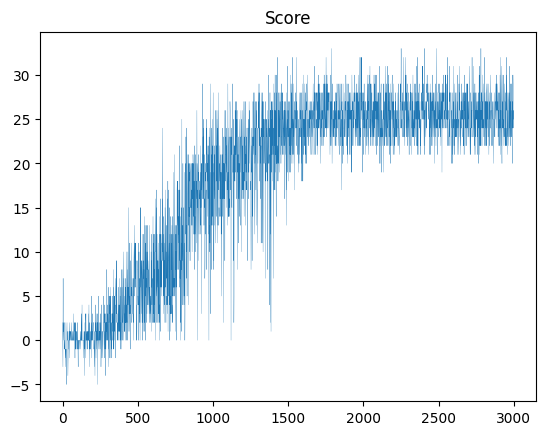

In [20]:
score = np.sum(reward_history, axis=-1)
plt.plot(score, linewidth=.2)
plt.title('Score')

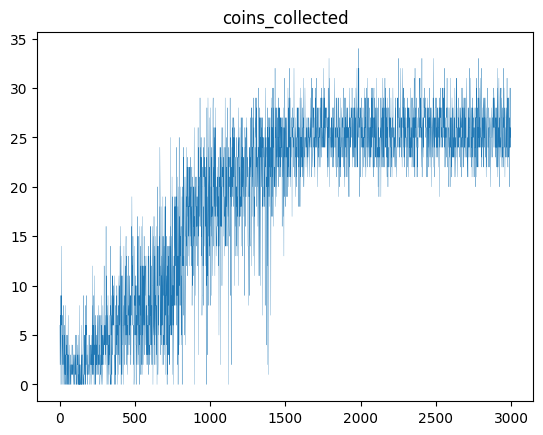

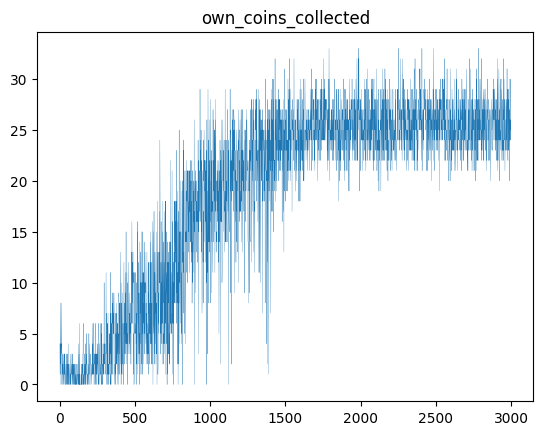

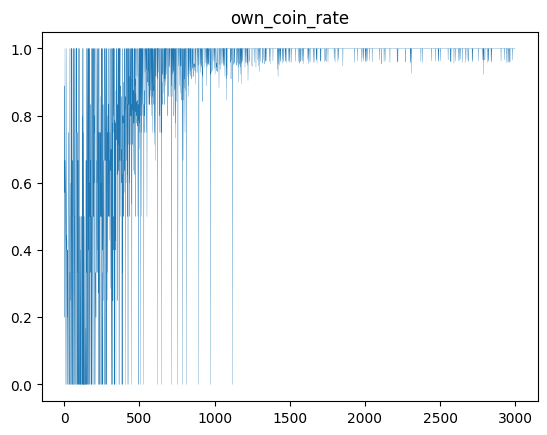

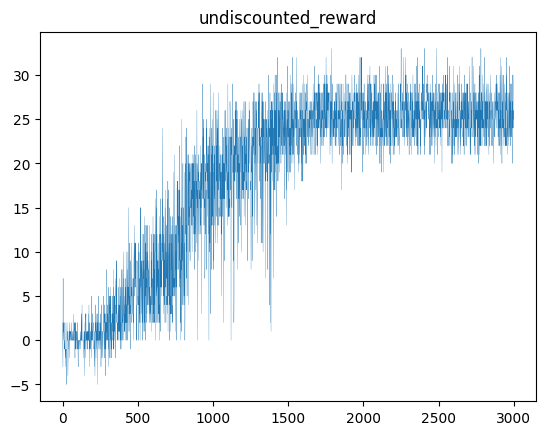

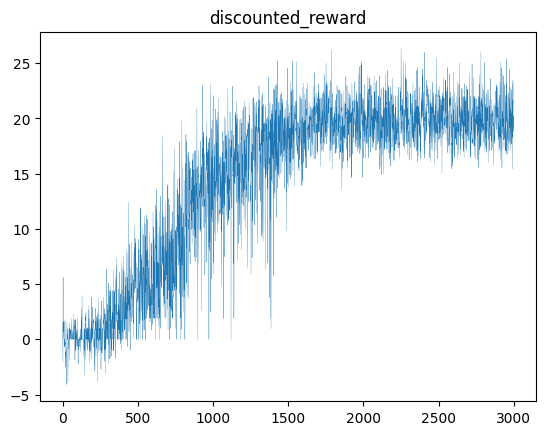

In [21]:
for k, v in metrics_history.items():
    plt.figure()
    plt.title(k)
    plt.plot(v, linewidth=.2)